<a href="https://colab.research.google.com/github/theroyakash/ResidualUNet/blob/master/residualUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual UNet paper implementation
Paper : https://arxiv.org/pdf/1711.10684.pdf

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
class ResidualUNet():

    def __init__(self, image_size):
        self.image_size = image_size
    
    def bn_act(self, x, act=True):
        x = keras.layers.BatchNormalization()(x)
        if act == True:
            x = keras.layers.Activation("relu")(x)
        return x

    def conv_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        conv = self.bn_act(x)
        conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
        return conv

    def stem(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        conv = self.conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
        
        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
        shortcut = self.bn_act(shortcut, act=False)
        
        output = keras.layers.Add()([conv, shortcut])
        return output

    def residual_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        res = self.conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
        res = self.conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
        
        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
        shortcut = self.bn_act(shortcut, act=False)
        
        output = keras.layers.Add()([shortcut, res])
        return output

    def upsample_concat_block(self, x, xskip):
        u = keras.layers.UpSampling2D((2, 2))(x)
        c = keras.layers.Concatenate()([u, xskip])
        return c

    def make_model(self):
        f = [16, 32, 64, 128, 256]
        inputs = keras.layers.Input((self.image_size, self.image_size, 3))
        
        ## Encoder
        e0 = inputs
        e1 = self.stem(e0, f[0])
        e2 = self.residual_block(e1, f[1], strides=2)
        e3 = self.residual_block(e2, f[2], strides=2)
        e4 = self.residual_block(e3, f[3], strides=2)
        e5 = self.residual_block(e4, f[4], strides=2)
        
        ## Bridge
        b0 = self.conv_block(e5, f[4], strides=1)
        b1 = self.conv_block(b0, f[4], strides=1)
        
        ## Decoder
        u1 = self.upsample_concat_block(b1, e4)
        d1 = self.residual_block(u1, f[4])
        
        u2 = self.upsample_concat_block(d1, e3)
        d2 = self.residual_block(u2, f[3])
        
        u3 = self.upsample_concat_block(d2, e2)
        d3 = self.residual_block(u3, f[2])
        
        u4 = self.upsample_concat_block(d3, e1)
        d4 = self.residual_block(u4, f[1])
        
        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
        model = keras.models.Model(inputs, outputs)
        return model

smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [3]:
residualUNet = ResidualUNet(128)
model = residualUNet.make_model()
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

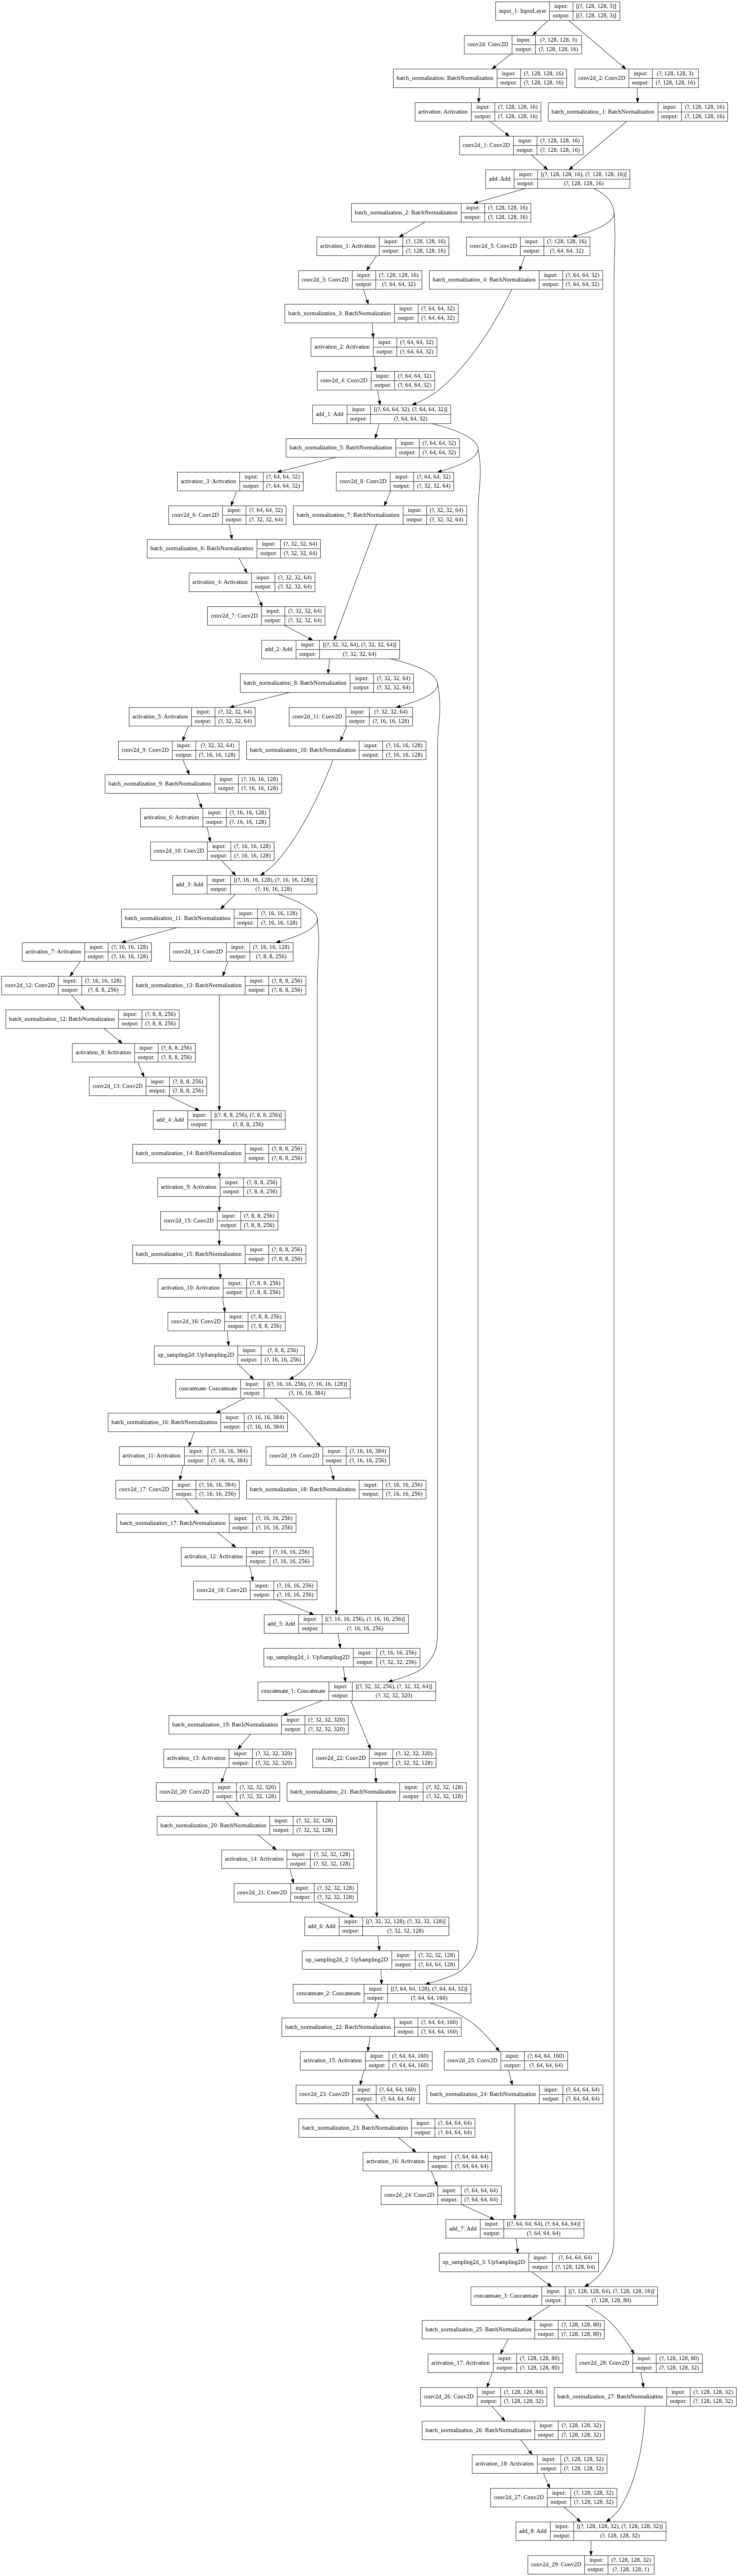

In [4]:
tf.keras.utils.plot_model(model, to_file='residualunet.png', show_shapes=True)